# Random Walk with Restart (système de recommandations)

Si la méthode de [factorisation de matrices](https://fr.wikipedia.org/wiki/Factorisation_de_matrices_pour_les_syst%C3%A8mes_de_recommandation) est la méthode la plus connue pour faire des recommandations, ce n'est pas la seule. L'algorithme [Random Walk with Restart](http://www2.cs.uh.edu/~ceick/7363/Papers/tong.pdf) s'appuie sur l'exploration locale des noeuds d'un graphe et produit des résultats plus facile à intepréter.)*.

*Ce notebook est inspiré de [Random Walk with Restart](http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx/notebooks/expose_rwr_recommandation.html)*.

Une des façons d'expliquer le [PageRank](http://fr.wikipedia.org/wiki/PageRank) est de modéliser Internet comme une immense [chaîne de Markov](http://fr.wikipedia.org/wiki/Cha%C3%AEne_de_Markov). Le score PageRank correspond alors à la probabilité de rester dans un état ou un site Internet dans ce cas-là. Ce score est relié à la probabilité d'atterrir sur un site en suivant une marche aléatoire à travers les hyperliens. Et pour éviter les problèmes numériques lors du calcul, la formule fait apparaître un terme $d$ qui correspond à la probabilité qu'un surfer a de continuer son chemin ou d'aller voir ailleurs sur un site qui n'a rien à voir : il fait un bond avec une probabilité $(1-d)$. Je ne réécris pas les formules, elles sont disponibles sur [Wikipedia](https://fr.wikipedia.org/wiki/).

Maintenant, si on considère qu'un surfeur se ballade sur Internet de façon aléatoire mais qu'au lieu d'arrêter sa marche et d'aller n'importe ou ailleurs, il revient à son point de départ. Cela revient à étudier toutes les marches aléatoires partant du même noeud. On obtient alors des probabilités de rester dans des états qui dépendent de ce point de départ qu'on utilise pour faire des recommandations [Fast Random Walk with Restart and Its Applications](http://www2.cs.uh.edu/~ceick/7363/Papers/tong.pdf)).

Je suppose qu'on a un graphe $(G,V,E)$, $V$ pour les noeuds, $E$ pour les arcs. $P$ représente la matrice de transition d'un noeud à l'autre. La somme des coefficients sur la même ligne fait 1 : $\sum_j P_{ij}=1$. $e$ est un vecteur avec que des 0 sauf pour une coordonnées $i$ où $i$ est le noeud de départ. $c$ est la probabilité de revenir au point de départ. L'objectif est de trouver le régime transition $\pi$ qui vérifie l'équation suivante :

$$\pi=(1-c)P'\pi+ce  \Longleftrightarrow \pi = c(I-(1-c)P')^{-1}e$$

Le vecteur $\pi$ qui en résulte donne un poids à chaque noeud du graphe et c'est ce poids dont on se sert pour ordonner les recommandations. Autrement dit, si un surfeur est sur un site $i$, on lui recommandera comme autre site ceux dont le poids est le plus fort dans le vecteur $\pi$. Le tout est savoir de le calculer. Exemple, on choisit pour $P$ :

In [1]:
%matplotlib inline

In [2]:
from papierstat.datasets import create_tiny_graph
P = create_tiny_graph()
P

matrix([[0.        , 0.5       , 0.        , 0.5       ],
        [0.5       , 0.        , 0.5       , 0.        ],
        [0.33333333, 0.33333333, 0.        , 0.33333333],
        [0.1       , 0.9       , 0.        , 0.        ]])

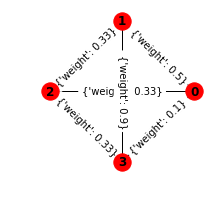

In [3]:
import networkx as nx
G = nx.Graph()
for i in range(0, max(P.shape)):
    G.add_node(i)
for i in range(0, P.shape[0]):
    for j in range(0, P.shape[1]):
        if P[i,j] !=0 :
            G.add_edge(i,j, weight=int(P[i,j] * 100)/100)
        
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(3,3))
pos = nx.shell_layout(G)
nx.draw(G, with_labels=True, font_weight='bold', ax=ax, pos=pos)
nx.draw_networkx_edge_labels(G, pos=pos);

La représentation n'est pas extraordinaire. Le module [networkx](https://networkx.github.io/) est utile pour obtenir les positions des noeuds projetés dans un plan. Le graphe peut être adapté ensuite.

In [4]:
import numpy
c = 0.15
I = numpy.identity(4)
e = numpy.matrix( [[ 0., 1., 0., 0. ]]).T
pi = ((I-P.T*(1-c))).I * e * c
pi

matrix([[0.24355828],
        [0.42249412],
        [0.17956   ],
        [0.1543876 ]])

Une autre de procéder est de considérer que le vecteur $\pi$ est un point fixe de la suite : $\pi^t = (1-c)P \pi^{t-1} +ce$. 

In [5]:
pi = e
for i in range(0,10):
    pi = P.T * pi * (1-c) + e * c
pi

matrix([[0.24350522],
        [0.42215404],
        [0.17924793],
        [0.15509282]])

On retrouve sensiblement la même chose. Une dernière façon est d'utiliser des marches aléatoires avec restart ou <i>Random Walk with Restart</i>. Mais pour ce faire, on doit générer des marches aléatoires partant de $i$ avec la probabilité de revenir au début égale à $c$.

In [6]:
import random
from numpy.random import multinomial

def marche_alea(P,c,i):
    marche = [ i ]
    while True:
        r = random.random()
        if r <= c: return marche
        vect = P[i,:].tolist()[0]
        i = multinomial(1,vect,size=1).tolist()[0].index(1)
        marche.append(i)

def aggregation(marches):
    count = {}
    for marche in marches:
        for i in marche : count[i] = count.get(i,0)+1.0
    s = sum( _ for _ in count.values())*1.0
    for i in count: count[i] /= s
    return [ count.get(i,0) for i in range(0,max(_ for _ in count.keys())+1) ]

marches = [ marche_alea(P,c,1) for k in range(0,1000) ]
count = aggregation(marches)
count 

[0.24901125646486158,
 0.4250076057195011,
 0.1753878916945543,
 0.15059324612108305]

On retrouve sensiblement les mêmes résultats. A quoi ça sert ? Selon les contextes, il est préférable d'utiliser tel ou tel algorithme pour calculer le vecteur $\pi$ : l'inversion de la matrice, la suite récursive, ou Monte Carlo voire une combinaison. Voici quelques questions qu'il faut se poser.

- la matrice est grande (plusieurs millions de noeuds) ou petite (quelques milliers) ?
- la matrice est [sparse](http://en.wikipedia.org/wiki/Sparse_matrix) ou creuse (ses coefficients sont presque tous nuls) ?
- on a besoin des valeurs pour seulement quelques noeuds et seulement les premières valeurs ?
- les calculs se font en parallèle sur la même machine (mémoire partagée) ou en map/reduce ?

Sur Internet, les matrices sont souvent très grandes, très sparses excepté pour quelques noeuds qui sont comme des hubs et qu'il faut parfois traiter à part.